# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «ХС» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта**

Построить модель, которая по фотографии определит приблизительный возраст человека.

**Этапы проекта**

- Проведение исследовательского анализа набора фотографий.

- Подготовка данных к обучению.

- Обучение нейронной сети и расчет её качества (с использованием метрики MAE)

**Описание данных**

Для выполнения данного проекта будет использоваться датасет с фотографиями людей и с указанием их возраста.
Данные взяты с сайта `ChaLearn Looking at People`. Они находятся в папке `/datasets/faces/`.
В нашем распоряжении одна папка со всеми изображениями `(/final_files)` и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`

# Импорт необходимых библиотек, загрузка, чтение данных

In [1]:
# !pip install -r requirements.txt
# при необходимости можно запустить данную команду, для установки версий библиотек,
#которые использовались при использовании данного проекта
# и с которыми не возникали конфликты




#Проведем необходимые импорты

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
try:
    df = pd.read_csv('/datasets/faces/labels.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/faces/labels.csv')

df.sample(7) #Вывод 7 случайных строк датасета.

,file_name,real_age
404,000404.jpg,41
4190,004190.jpg,6
4757,004757.jpg,43
6247,006251.jpg,28
3874,003874.jpg,26
3587,003587.jpg,6
93,000093.jpg,59


**Изучим датасет более подробно:**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Датасет содержит два столбца, всего 7591 запись.
Правила хорошего стиля в названии столбцов соблюдены.
Тип данных соответствует содержимому столбцов, поэтому смена типа данных при исследовании не требуется. Пропусков при выполнении шага не выявлено.

In [4]:
df.describe() #Описательная статистика датасета

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Данные описательной статистики указывают на то, что в целом, больше людей в датасете молодого и среднего возраста. Аномальных значений не наблюдается (возраст 100 имеет место быть), но изучим этот аспект при построении гистограммы, так как визуально будет более ясно.

Построим гистограмму распределения возраста, а также диаграмму ящик с усами:

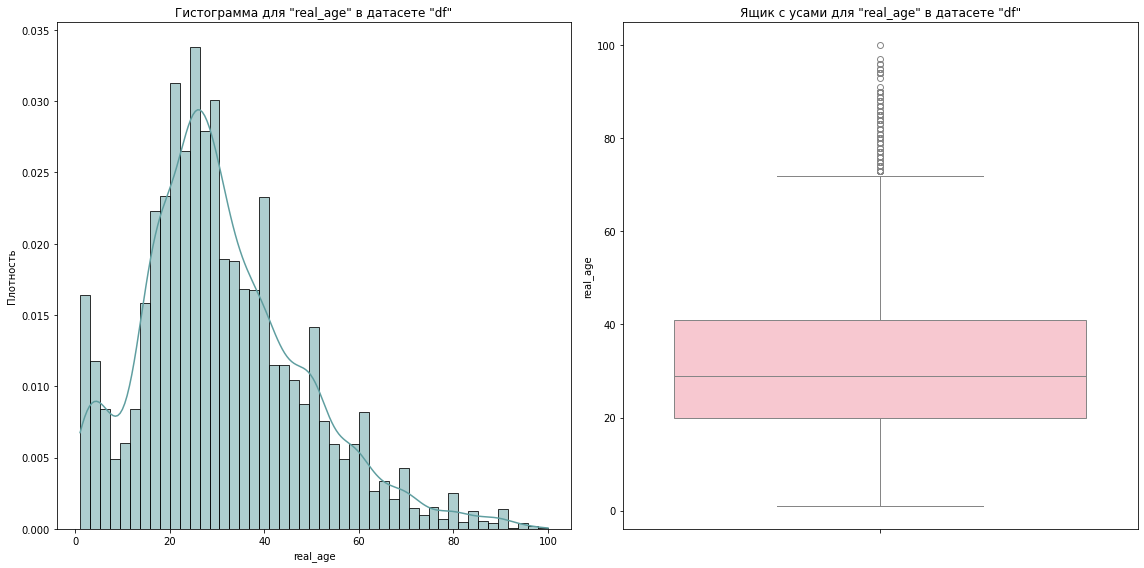

In [5]:
col = 'real_age'

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].set_title(f'Гистограмма для "{col}" в датасете "df"')
axes[1].set_title(f'Ящик с усами для "{col}" в датасете "df"')

# Гистограмма
sns.histplot(
    df[col],
    stat='density',
    common_norm=False,
    kde=True,
    color='cadetblue',
    ec='black',
    ax=axes[0]
)
axes[0].set_xlabel(col)
axes[0].set_ylabel('Плотность')

# Диаграмма "ящик с усами"
sns.boxplot(
    y=df[col],
    color='pink',
    ax=axes[1]
)
axes[1].set_ylabel(col)

plt.tight_layout()
plt.show()

Визуализация данных подтвердила, что больше всего в датасете присутствуют изображения людей молодого и среднего возраста, потому люди пожилого возраст (от 60) больше воспринимаются как выбросы в датасете. Но избавляться от них мы конечно не будет, так как это данные для обучения.
И также присутствует умеренное количество детей.

В целом, в датасете присутствует большой разброс возрастов, что позволит модели в будущем показывать более точный результат, вввиду обучения на разных возрастных группах, однако лучше всего она будет распознавать лиц в  возрасте от 18 до 40, так как их больше представлено.

Проведем предобработку изображений перед подачей в модель.

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


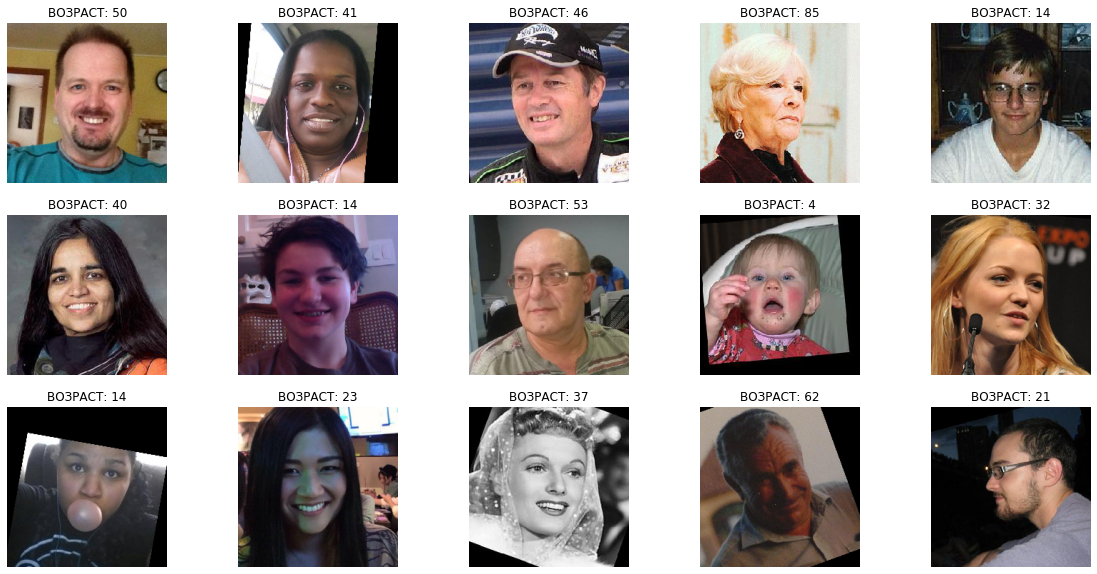

In [7]:
#Код, позволяющий вывести 15 изображений из файла:

images, labels = next(train_gen_flow)
plt.figure(figsize=(20, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'ВОЗРАСТ: {labels[i]}')
    plt.axis('off')

plt.show()

**Вывод по исследовательскому анализу данных:**

- Был загружен датасет, содержащий в себе фотографии людей с указанием их реального возраста

- Датасет содержит 7591 запись, пропусков нет, все типы данных и названия столбцов корректные

- Визуализировали распределение возраста в датасете. Больше всего людей молодого и среднего возраста (20-40 лет), так же присутствует умеренное количество детей и подростков (от 1 до 20) лет, а так же пожилые люди. 

Такое распределение возрастов делает данные более информативными.

Далее провели подготовку изображений, привели их к опр. размеру.

Вывели 15 изображений.

Несмотря на то, что по возрастам разнообразие большое, что может помочь модели корректно обучиться, стоит отметить, что некоторые фотографии перевернуты, либо с плохим освещением, сделаны издалека,либо с присутствием посторонних предметов, что может немного затруднить обучение модели, так как свет, ракурс могут влиять на черты лица, исказить их, изучим данный аспект в дальнейшем анализе.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    optimizer = Adam(lr=1e-5)
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):


    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```


2025-02-05 21:35:26.465652: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-02-05 21:35:26.826822: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 80s - loss: 605.9410 - mae: 19.6419 - val_loss: 777.9918 - val_mae: 22.9755
Epoch 2/10
356/356 - 48s - loss: 135.9957 - mae: 8.7275 - val_loss: 254.7379 - val_mae: 11.8735
Epoch 3/10
356/356 - 48s - loss: 81.7185 - mae: 6.8498 - val_loss: 86.3647 - val_mae: 6.9668
Epoch 4/10
356/356 - 47s - loss: 59.4481 - mae: 5.8651 - val_loss: 101.4630 - val_mae: 7.5887
Epoch 5/10
356/356 - 48s - loss: 46.0201 - mae: 5.2026 - val_loss: 86.9336 - val_mae: 6.9656
Epoch 6/10
356/356 - 48s - loss: 37.5295 - mae: 4.6988 - val_loss: 81.1697 - val_mae: 6.7086
Epoch 7/10
356/356 - 48s - loss: 30.4836 - mae: 4.2698 - val_loss: 87.3631 - val_mae: 6.9607
Epoch 8/10
356/356 - 48s - loss: 27.7582 - mae: 4.0580 - val_loss: 79.8057 - val_mae: 6.7285
Epoch 9/10
356/356 - 48s - loss: 25.7344 - mae: 3.9422 - val_loss: 81.8294 - val_mae: 6.7858
Epoch 10/10
356/356 - 48s - loss: 23.4567 - mae: 3.7268 - val_loss: 78.7966 - val_mae: 6.6836
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 78.7966 - mae: 6.6836

```

## Анализ обученной модели

Была обучена модель для определения возраста покупателей ResNet50. Качество модели было проверено с помощью метрики MAE (по заданию метрика должна быть менее 8). В результате обучения получился результат 6,68 -  модель ошибается  меньше, чем на 7 лет, что удовлетворяет условиям задачи и говорит о том, что модель ошибается не так часто, и хорошо предсказывает возраст покупателей в зависимости от посылаемых данных. 

Несмотря на то, что по возрастам разнообразие большое, что может помочь модели корректно обучиться, стоит отметить, что некоторые фотографии перевернуты, либо с плохим освещением, сделаны издалека,либо с присутствием посторонних предметов, что может влиять на результат.
Возможно, для совершенствования работы модели можно порекомендовать поработать и обучить модель на датасете с более аккуратными данными, а также, например, дополнительно применить аугментацию. 